In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# load the dataset
training_df = pd.read_excel('linear_selected_features.xlsx')

training_df.head()

,1891,1894,1898,1902,1905,1907,1910,1968,1971,1979,1982,1985,1988,Water Potential (Mpa)
0,0.0814,0.0678,0.0574,0.0311,0.0284,0.0269,0.0259,0.0336,0.0347,0.0395,0.0410,0.0430,0.0448,-0.089632
1,0.0983,0.0855,0.0757,0.0515,0.0490,0.0464,0.0446,0.0522,0.0534,0.0580,0.0598,0.0615,0.0631,-0.148237
2,0.0633,0.0533,0.0459,0.0282,0.0251,0.0238,0.0230,0.0280,0.0290,0.0321,0.0333,0.0347,0.0359,-0.128243
3,0.0969,0.0831,0.0734,0.0493,0.0456,0.0433,0.0421,0.0475,0.0487,0.0531,0.0550,0.0564,0.0579,-0.164785
4,0.0784,0.0662,0.0573,0.0336,0.0317,0.0301,0.0286,0.0343,0.0354,0.0391,0.0406,0.0421,0.0438,-0.326122


In [3]:
# ---------------------------------
# Define predictors and target
# ---------------------------------
X = training_df.drop(columns = ['Water Potential (Mpa)'])
y = training_df['Water Potential (Mpa)']

In [4]:
# Feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# <font color = Orange> Multiple Linear Regression - PLSR

In [5]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for n_components to be integers between 1 and the number of features
    n_components = trial.suggest_int('n_components', 1, X_train.shape[1])
    # Set the range for max_iter to be between 100 and 1000
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Create the PLSR model with the specified hyperparameters
    model = PLSRegression(n_components=n_components, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_plsr = PLSRegression(n_components=trial.params['n_components'], max_iter=trial.params['max_iter'])

# Fit the model
best_plsr.fit(X_train, y_train)

# Make predictions
y_pred = best_plsr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 20:37:24,674] A new study created in memory with name: no-name-bdb4562c-7cb1-430b-b5dd-b37649e507f4
[I 2024-02-25 20:37:24,690] Trial 0 finished with value: 2.1848467101830353 and parameters: {'n_components': 13, 'max_iter': 518}. Best is trial 0 with value: 2.1848467101830353.
[I 2024-02-25 20:37:24,698] Trial 1 finished with value: 2.18679014111948 and parameters: {'n_components': 3, 'max_iter': 624}. Best is trial 0 with value: 2.1848467101830353.
[I 2024-02-25 20:37:24,718] Trial 2 finished with value: 2.2237628926666546 and parameters: {'n_components': 9, 'max_iter': 716}. Best is trial 0 with value: 2.1848467101830353.
[I 2024-02-25 20:37:24,728] Trial 3 finished with value: 1.861568719657534 and parameters: {'n_components': 2, 'max_iter': 771}. Best is trial 3 with value: 1.861568719657534.
[I 2024-02-25 20:37:24,736] Trial 4 finished with value: 1.803735752930941 and parameters: {'n_components': 4, 'max_iter': 778}. Best is trial 4 with value: 1.803735752930941.
[

[I 2024-02-25 20:37:26,075] Trial 46 finished with value: 1.861568719657534 and parameters: {'n_components': 2, 'max_iter': 828}. Best is trial 11 with value: 1.501555991529998.
[I 2024-02-25 20:37:26,107] Trial 47 finished with value: 1.803735752930941 and parameters: {'n_components': 4, 'max_iter': 670}. Best is trial 11 with value: 1.501555991529998.
[I 2024-02-25 20:37:26,142] Trial 48 finished with value: 2.1467817129351556 and parameters: {'n_components': 11, 'max_iter': 763}. Best is trial 11 with value: 1.501555991529998.
[I 2024-02-25 20:37:26,189] Trial 49 finished with value: 1.9310264605652192 and parameters: {'n_components': 5, 'max_iter': 999}. Best is trial 11 with value: 1.501555991529998.
[I 2024-02-25 20:37:26,219] Trial 50 finished with value: 2.18679014111948 and parameters: {'n_components': 3, 'max_iter': 210}. Best is trial 11 with value: 1.501555991529998.
[I 2024-02-25 20:37:26,258] Trial 51 finished with value: 1.501555991529998 and parameters: {'n_components':

[I 2024-02-25 20:37:27,694] Trial 93 finished with value: 1.861568719657534 and parameters: {'n_components': 2, 'max_iter': 600}. Best is trial 11 with value: 1.501555991529998.
[I 2024-02-25 20:37:27,733] Trial 94 finished with value: 1.501555991529998 and parameters: {'n_components': 1, 'max_iter': 800}. Best is trial 11 with value: 1.501555991529998.
[I 2024-02-25 20:37:27,771] Trial 95 finished with value: 1.501555991529998 and parameters: {'n_components': 1, 'max_iter': 876}. Best is trial 11 with value: 1.501555991529998.
[I 2024-02-25 20:37:27,810] Trial 96 finished with value: 1.861568719657534 and parameters: {'n_components': 2, 'max_iter': 631}. Best is trial 11 with value: 1.501555991529998.
[I 2024-02-25 20:37:27,844] Trial 97 finished with value: 1.501555991529998 and parameters: {'n_components': 1, 'max_iter': 537}. Best is trial 11 with value: 1.501555991529998.
[I 2024-02-25 20:37:27,879] Trial 98 finished with value: 1.861568719657534 and parameters: {'n_components': 2

Number of finished trials:  100
Best trial:
  Value: 1.501555991529998
  Params: 
    n_components: 1
    max_iter: 793
Mean Squared Error: 1.501555991529998
Root Mean Squared Error: 1.2253799376234287
R-Squared value: 0.5011321867238978


In [6]:
# Get the coefficients from the trained PLSRegression model
coefficients = best_plsr.coef_.flatten()

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")

Top 3 Features:
1898: -0.061469107606128164
1894: -0.06131703740827712
1902: -0.06088129000116553


# <font color = Blue> Elastic Net

In [7]:
# Tune the hyperparameters using Optuna
def objective(trial):
    
    # Set the range for alpha to be uniform between 0.0 and 1.0, alpha is the regularization parameter
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for l1_ratio to be uniform between 0.0 and 1.0, l1_ratio is the ElasticNet mixing parameter
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    # Set the range for max_iter to be between 100 and 1000, max_iter is the maximum number of iterations
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    # Create the ElasticNet model with the specified hyperparameters
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    # Return mse as the objective value
    return mse

# Create the Optuna study, we maximize the objective function (the score)
# model.score() returns the coefficient of determination R^2 of the prediction 
# i.e. the percentage of the variance in the target variable that is predictable from the feature variables
study = optuna.create_study(direction='minimize', sampler = TPESampler(seed=37))
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial

# Print the value of the final trial and the best parameters
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_elastic_net = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio'], max_iter=study.best_params['max_iter'])

# Fit the model
best_elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = best_elastic_net.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 20:37:28,003] A new study created in memory with name: no-name-940ffeff-d500-4639-b192-c016b6d3eb3d
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:37:28,032] Trial 0 finished with value: 2.5506203576719617 and parameters: {'alpha': 0.9444966028573069, 'l1_ratio': 0.4640981743044076, 'max_iter': 273}. Best is trial 0 with value: 2.5506203576719617.
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:37:28,256] Trial 9 finished with value: 1.686182515230845 and parameters: {'alpha': 0.47841987416050147, 'l1_ratio': 0.17893744751587604, 'max_iter': 913}. Best is trial 7 with value: 1.5426808869547484.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:37:28,615] Trial 18 finished with value: 1.5599920515049497 and parameters: {'alpha': 0.1576797983469223, 'l1_ratio': 0.16390791650330228, 'max_iter': 303}. Best is trial 7 with value: 1.5426808869547484.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.337e-01, tolerance: 5.990e-03
  model = cd_fast.enet_coordinat

[I 2024-02-25 20:37:29,207] Trial 36 finished with value: 1.6250407965647247 and parameters: {'alpha': 0.1741649262581202, 'l1_ratio': 0.4193581136191026, 'max_iter': 186}. Best is trial 25 with value: 1.5213832558626057.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:37:29,245] Trial 37 finished with value: 1.903850630093978 and parameters: {'alpha': 0.8396179124594347, 'l1_ratio'

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:37:29,595] Trial 46 finished with value: 1.5712423382079914 and parameters: {'alpha': 0.3123511558005154, 'l1_ratio': 0.06272472991450398, 'max_iter': 516}. Best is trial 25 with value: 1.5213832558626057.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

[I 2024-02-25 20:37:29,942] Trial 54 finished with value: 1.6341249421741004 and parameters: {'alpha': 0.10908150496501495, 'l1_ratio': 0.8908628249428381, 'max_iter': 213}. Best is trial 25 with value: 1.5213832558626057.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:37:30,018] Trial 55 finished with value: 1.533827270278182 and parameters: {'alpha': 0.15130628566557963, 'l1_rati

[I 2024-02-25 20:37:30,325] Trial 63 finished with value: 1.544667797743099 and parameters: {'alpha': 0.18850623850697729, 'l1_ratio': 0.04166048783223958, 'max_iter': 544}. Best is trial 25 with value: 1.5213832558626057.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:37:30,360] Trial 64 finished with value: 1.5452062929372807 and parameters: {'alpha': 0.11654070833369592, 'l1_rat

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:37:30,697] Trial 73 finished with value: 1.558755114898151 and parameters: {'alpha': 0.1992281848996889, 'l1_ratio': 0.08881797036645275, 'max_iter': 206}. Best is trial 25 with value: 1.5213832558626057.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.744e-01, tolerance: 5.990e-03
  model = cd_fast.enet_coordinate_descent(
[I 2024-02-25 20:37:30,998] Trial 81 finished with value: 1.5202680265519641 and parameters: {'alpha': 0.07175819883530099, 'l1_ratio': 0.11683194888143424, 'max_iter': 107}. Best is trial 81 with value: 1.5202680265519641.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: Fut

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.361e-01, tolerance: 5.990e-03
  model = cd_fast.enet_coordinat

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 20:37:31,893] Trial 98 finished with value: 1.5123230743796754 and parameters: {'alpha': 0.04866898409742097, 'l1_ratio': 0.2464076037828447, 'max_iter': 150}. Best is trial 98 with value: 1.5123230743796754.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

Number of finished trials:  100
Best trial:
  Value: 1.5123230743796754
  Params: 
    alpha: 0.04866898409742097
    l1_ratio: 0.2464076037828447
    max_iter: 150
Mean Squared Error: 1.5123230743796754
Root Mean Squared Error: 1.229765455027777
R-Squared value: 0.49755499672440395


In [8]:
# Get the coefficients from the trained ElasticNet model
coefficients = best_elastic_net.coef_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")


Top 3 Features:
1898: -0.27756322029525954
1894: -0.24061425489963287
1902: -0.19038317174394745


# <font color = Red> Non-linear Kernel Ridge Regression (KRR)

In [9]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for alpha to be uniform between 0.0 and 1.0
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for gamma to be loguniform between 1e-6 and 1e6
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
    # Set the range for kernel to be categorical between 'linear' and 'rbf'
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    
    # Create the Kernel Ridge Regression model with the specified hyperparameters
    model = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

# Fit the model
best_krr.fit(X_train, y_train)

# Make predictions
y_pred = best_krr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 20:37:31,997] A new study created in memory with name: no-name-ca614448-b0b0-432a-a070-8affdabb2a92
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:37:32,029] Trial 0 finished with value: 4.640798890562222 and parameters: {'alpha': 0.9444966028573069, 'gamma': 0.3708327584362581, 'kernel': 'rbf'}. Best is trial 0 with value: 4.640798890562222.
/var/folder

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:37:32,157] Trial 10 finished with value: 1.972098560424653 and parameters: {'alpha': 0.003915949640957761, 'gamma': 8.218006795527931e-06, 'kernel': 'rbf'}. Best is trial 10 with value: 1.972098560424653.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has be

[I 2024-02-25 20:37:32,407] Trial 19 finished with value: 2.544389459218669 and parameters: {'alpha': 0.2533899667693353, 'gamma': 0.07425657734301377, 'kernel': 'rbf'}. Best is trial 12 with value: 1.5561542150460936.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:37:32,439] Trial 20 finished with value: 1.909341011026023 and parameters: {'alpha': 0.09214436620061181

[I 2024-02-25 20:37:32,686] Trial 29 finished with value: 4.682821767598681 and parameters: {'alpha': 0.9668894200089733, 'gamma': 0.40089333133208455, 'kernel': 'rbf'}. Best is trial 12 with value: 1.5561542150460936.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:37:32,718] Trial 30 finished with value: 3.2003463103984684 and parameters: {'alpha': 0.4120625539246667

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:37:33,045] Trial 40 finished with value: 6.197462058662679 and parameters: {'alpha': 0.1626149877957284, 'gamma': 9917.754841169393, 'kernel': 'rbf'}. Best is trial 12 with value: 1.5561542150460936.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has been de

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:37:33,350] Trial 49 finished with value: 4.2783931599280045 and parameters: {'alpha': 0.05947426629419983, 'gamma': 0.22608592746888576, 'kernel': 'rbf'}. Best is trial 12 with value: 1.5561542150460936.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:6: FutureWarning: suggest_loguniform has 

[I 2024-02-25 20:37:33,666] Trial 58 finished with value: 1.6812185313151107 and parameters: {'alpha': 0.18488118896212397, 'gamma': 0.005624919802876106, 'kernel': 'rbf'}. Best is trial 12 with value: 1.5561542150460936.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:37:33,712] Trial 59 finished with value: 1.8346730479328934 and parameters: {'alpha': 0.0913646615917

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:37:33,988] Trial 69 finished with value: 4.358512303526579 and parameters: {'alpha': 0.5444506291845654, 'gamma': 0.00043302815057178623, 'kernel': 'linear'}. Best is trial 12 with value: 1.5561542150460936.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:37:34,273] Trial 79 finished with value: 4.8371593751694215 and parameters: {'alpha': 0.16591399571814847, 'gamma': 0.5267926592476261, 'kernel': 'rbf'}. Best is trial 12 with value: 1.5561542150460936.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has been

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:37:34,539] Trial 88 finished with value: 3.0686782695651833 and parameters: {'alpha': 0.02004805423661886, 'gamma': 4.1813773928178176e-06, 'kernel': 'rbf'}. Best is trial 12 with value: 1.5561542150460936.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:6: FutureWarning: suggest_loguniform h

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 20:37:34,811] Trial 98 finished with value: 2.0921061189736707 and parameters: {'alpha': 0.018078399350584327, 'gamma': 2.871336827929106e-05, 'kernel': 'rbf'}. Best is trial 96 with value: 1.5467008156430202.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/295769073.py:4: FutureWarning: suggest_uniform has 

Number of finished trials:  100
Best trial:
  Value: 1.5467008156430202
  Params: 
    alpha: 0.016559926804234494
    gamma: 0.0008609146056417835
    kernel: rbf
Mean Squared Error: 1.5467008156430202
Root Mean Squared Error: 1.2436642696656603
R-Squared value: 0.4861335454390998


In [10]:
# Get the dual coefficients from the trained KernelRidge model
coefficients = best_krr.dual_coef_

# Calculate the squared magnitude of coefficients (as they are signed)
squared_magnitude = np.abs(coefficients) ** 2

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, squared_magnitude))

# Sort the features by their squared magnitude (importance)
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, magnitude in sorted_features[:top_n]:
    print(f"{feature}: {magnitude}")


Top 3 Features:
1971: 19155.548476507192
1902: 17537.330210819942
1894: 2659.2801927478217


# Principal Component Regression (PCR)

Number of components that explain at least 95% of the variance: 1


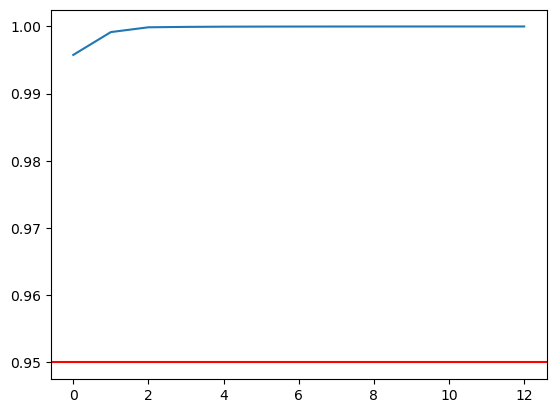

In [11]:
# Create an instance of PCA
pca = PCA(random_state= 37)

# Perform PCA on the predictors DataFrame
pca.fit(X)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance with a vertical line at 95%
plt.plot(cumulative_explained_variance)
plt.axhline(y=0.95, color='r', linestyle='-')

# Find the number of components that explain at least 95% of the variance
pca_n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f'Number of components that explain at least 95% of the variance: {pca_n_components}')

In [12]:
# Define the number of principal components to retain
n_components = pca_n_components

# Create a pipeline with PCA and Linear Regression
pipeline = make_pipeline(PCA(n_components), LinearRegression())

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 1.50212714203699
Root Mean Squared Error: 1.2256129658407624
R-Squared value: 0.5009424311596152


In [13]:
# Get the principal components from the trained PCA model within the pipeline
principal_components = pipeline.named_steps['pca'].components_

# Calculate the squared loadings of each feature on the principal components
squared_loadings = principal_components ** 2

# Sum the squared loadings across principal components to get feature importance
feature_importance = squared_loadings.sum(axis=0)

# Get the names of the original features
feature_names = X.columns

# Create a dictionary to store feature importance with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
1910: 0.07940359224728744
1907: 0.07909687118516859
1905: 0.07870109923937724


# <font color = Purple> Ensemble Methods

## <font color = darkgreen> Random Forest Regression

In [14]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the Random Forest model with the specified hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Random Forest model using the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    min_samples_split=trial.params['min_samples_split'], 
    min_samples_leaf=trial.params['min_samples_leaf']
)

# Fit the model
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 20:37:35,313] A new study created in memory with name: no-name-d684a619-d100-49d9-8ed4-513bcb080da8
[I 2024-02-25 20:37:35,553] Trial 0 finished with value: 2.780259172017061 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 2.780259172017061.
[I 2024-02-25 20:37:35,726] Trial 1 finished with value: 3.0007500518089363 and parameters: {'n_estimators': 112, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 2.780259172017061.
[I 2024-02-25 20:37:35,850] Trial 2 finished with value: 2.7523430562472826 and parameters: {'n_estimators': 78, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 2 with value: 2.7523430562472826.
[I 2024-02-25 20:37:35,998] Trial 3 finished with value: 1.991748421803935 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 3 with value: 1.

[I 2024-02-25 20:37:41,214] Trial 36 finished with value: 1.851918803106213 and parameters: {'n_estimators': 54, 'max_depth': 25, 'min_samples_split': 16, 'min_samples_leaf': 2}. Best is trial 11 with value: 1.5176377279981488.
[I 2024-02-25 20:37:41,433] Trial 37 finished with value: 2.831098186962534 and parameters: {'n_estimators': 117, 'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 11 with value: 1.5176377279981488.
[I 2024-02-25 20:37:41,549] Trial 38 finished with value: 2.213709481035209 and parameters: {'n_estimators': 50, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 4}. Best is trial 11 with value: 1.5176377279981488.
[I 2024-02-25 20:37:41,692] Trial 39 finished with value: 2.136747300083836 and parameters: {'n_estimators': 70, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 2}. Best is trial 11 with value: 1.5176377279981488.
[I 2024-02-25 20:37:41,943] Trial 40 finished with value: 1.875891616347156 and paramet

[I 2024-02-25 20:37:47,405] Trial 72 finished with value: 1.5937708826799912 and parameters: {'n_estimators': 124, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 1}. Best is trial 61 with value: 1.5127489897018764.
[I 2024-02-25 20:37:47,631] Trial 73 finished with value: 2.0086971297003857 and parameters: {'n_estimators': 131, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 2}. Best is trial 61 with value: 1.5127489897018764.
[I 2024-02-25 20:37:47,867] Trial 74 finished with value: 1.6603590925580465 and parameters: {'n_estimators': 127, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 1}. Best is trial 61 with value: 1.5127489897018764.
[I 2024-02-25 20:37:48,074] Trial 75 finished with value: 2.010093445220103 and parameters: {'n_estimators': 112, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 2}. Best is trial 61 with value: 1.5127489897018764.
[I 2024-02-25 20:37:48,373] Trial 76 finished with value: 1.6223766692136294 and par

Best trial:
  Value: 1.5127489897018764
  Params: 
    n_estimators: 105
    max_depth: 11
    min_samples_split: 19
    min_samples_leaf: 1
Mean Squared Error: 1.7123704843633372
Root Mean Squared Error: 1.3085757465134897
R-Squared value: 0.4310924641694842


## <font color = darkblue> Variable Importance Information of RF

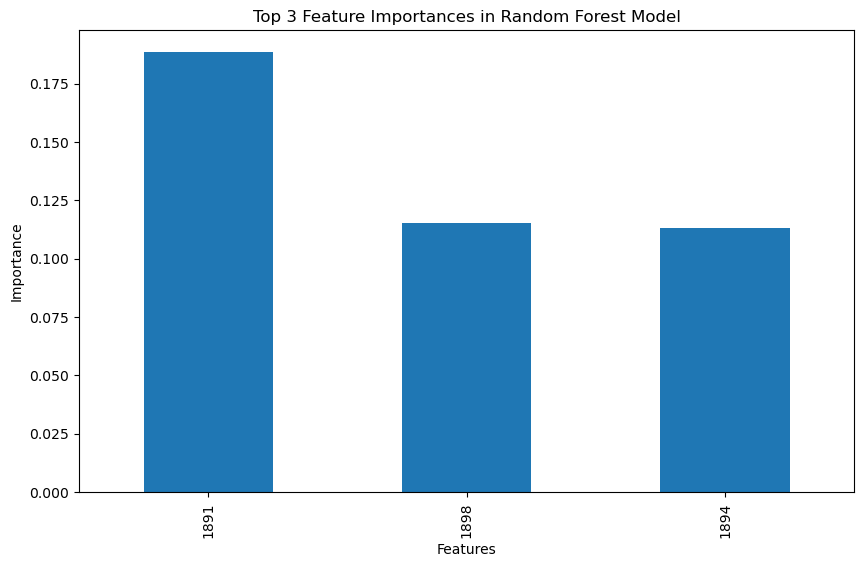

In [15]:
# Extract feature importances
feature_importances = best_rf_model.feature_importances_

# Create a series with feature names and their importance
features = pd.Series(feature_importances, index = X.columns)

# Sort the features by importance
features = features.sort_values(ascending=False)

# Select the top 3 features
top_3_features = features[:3]

# Plot the top 3 feature importances
plt.figure(figsize=(10, 6))
top_3_features.plot(kind='bar')
plt.title('Top 3 Feature Importances in Random Forest Model')
plt.ylabel('Importance')
plt.xlabel('Features')

plt.show()

## <font color = darkgreen> Gradient Boosting Regression

In [16]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Adjust the range for max_depth
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
    
    # Create the Gradient Boosting model with the specified hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate  # Pass learning_rate to the model
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Gradient Boosting model using the best parameters
best_gb_model = GradientBoostingRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate']  # Pass learning_rate to the model
)

# Fit the model
best_gb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_gb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))


[I 2024-02-25 20:37:53,949] A new study created in memory with name: no-name-d6241335-35ae-435f-b05d-a53b1270efb7
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:37:54,145] Trial 0 finished with value: 1.8453708408989775 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.027351552606144185}. Best is trial 0 with value: 1.8453708408989775.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.sugg

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:37:56,220] Trial 14 finished with value: 1.6209361080505011 and parameters: {'n_estimators': 83, 'max_depth': 4, 'learning_rate': 0.012326639396245958}. Best is trial 13 with value: 1.3863732561176525.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:37:56,338] Trial 15 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:37:58,052] Trial 28 finished with value: 1.455380098417885 and parameters: {'n_estimators': 56, 'max_depth': 3, 'learning_rate': 0.043352039178974996}. Best is trial 13 with value: 1.3863732561176525.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:37:58,316] Trial 29 f

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:37:59,980] Trial 42 finished with value: 1.468314802855567 and parameters: {'n_estimators': 73, 'max_depth': 3, 'learning_rate': 0.04222326549825525}. Best is trial 13 with value: 1.3863732561176525.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:38:00,123] Trial 43 fi

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:38:02,081] Trial 56 finished with value: 1.4483829710926683 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.03216960169577643}. Best is trial 55 with value: 1.3744614130187252.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:38:02,235] Trial 57 f

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:38:03,744] Trial 70 finished with value: 1.8690659584507983 and parameters: {'n_estimators': 89, 'max_depth': 5, 'learning_rate': 0.04066154859506383}. Best is trial 58 with value: 1.344154757719123.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:38:03,832] Trial 71 fi

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:38:04,983] Trial 84 finished with value: 1.386326373153276 and parameters: {'n_estimators': 57, 'max_depth': 3, 'learning_rate': 0.042262838300666794}. Best is trial 58 with value: 1.344154757719123.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:38:05,080] Trial 85 fi

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:38:06,473] Trial 98 finished with value: 1.3784553984462191 and parameters: {'n_estimators': 55, 'max_depth': 3, 'learning_rate': 0.047397025907508945}. Best is trial 92 with value: 1.3150742654162773.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 20:38:06,612] Trial 99 

Best trial:
  Value: 1.3150742654162773
  Params: 
    n_estimators: 50
    max_depth: 3
    learning_rate: 0.04546262988495359
Mean Squared Error: 1.3623148898671158
Root Mean Squared Error: 1.167182457830444
R-Squared value: 0.547392801910108


In [17]:
# Get feature importances from the trained GradientBoostingRegressor model
feature_importances = best_gb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


Top 3 Features:
1891: 0.18346005164963586
1905: 0.13631396783404637
1971: 0.12834911467987967


## <font color = green> XGBoost

In [18]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    
    # Create the XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the XGBoost model using the best parameters
best_xgb_model = XGBRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate'],
    min_child_weight=trial.params['min_child_weight'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

# Fit the model
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 20:38:06,703] A new study created in memory with name: no-name-d96ded21-f6e5-449f-8d33-00a74de4bce9
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[I 2024-02-25 20:38:08,535] Trial 6 finished with value: 2.078833949704865 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.08254345345232203, 'min_child_weight': 5, 'subsample': 0.5018019421849012, 'colsample_bytree': 0.7326167078381765}. Best is trial 3 with value: 1.9816332004582586.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9gr

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 20:38:15,536] Trial 26 finished with value: 2.6756247942760623 and parameters: {'n_estimators': 137, 'max_depth': 3, 'learning_rate': 0.020425878694854342, 'min_child_weight': 1, 'subsample': 0.5051409711780949, 'colsample_bytree': 0.6356617042091196}. Best is trial 25 with value: 1.7481610422451475.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 20:38:21,336] Trial 39 finished with value: 1.9709806490772481 and parameters: {'n_estimators': 142, 'max_depth': 4, 'learning_rate': 0.023132651645895758, 'min_child_weight': 4, 'subsample': 0.5235926913220901, 'colsample_bytree': 0.860007226237836}. Best is trial 25 with value: 1.7481610422451475.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 20:38:26,560] Trial 52 finished with value: 1.700629103251896 and parameters: {'n_estimators': 111, 'max_depth': 3, 'learning_rate': 0.08879070429825624, 'min_child_weight': 3, 'subsample': 0.5700887672003885, 'colsample_bytree': 0.798972536732192}. Best is trial 46 with value: 1.6417807870043317.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 20:38:30,431] Trial 65 finished with value: 1.7629962465693565 and parameters: {'n_estimators': 78, 'max_depth': 9, 'learning_rate': 0.06782798560297806, 'min_child_weight': 3, 'subsample': 0.6725941823067612, 'colsample_bytree': 0.7252367114928738}. Best is trial 46 with value: 1.6417807870043317.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 20:38:34,446] Trial 78 finished with value: 1.930159370111985 and parameters: {'n_estimators': 127, 'max_depth': 9, 'learning_rate': 0.04796435869716408, 'min_child_weight': 4, 'subsample': 0.5516553016203897, 'colsample_bytree': 0.7635217753608812}. Best is trial 46 with value: 1.6417807870043317.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 20:38:38,123] Trial 91 finished with value: 1.7840436578474232 and parameters: {'n_estimators': 110, 'max_depth': 6, 'learning_rate': 0.09753067298190479, 'min_child_weight': 3, 'subsample': 0.6352871345619755, 'colsample_bytree': 0.7019525628627649}. Best is trial 46 with value: 1.6417807870043317.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_44466/3853135105.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

Best trial:
  Value: 1.6287533715825326
  Params: 
    n_estimators: 98
    max_depth: 5
    learning_rate: 0.08767588486279629
    min_child_weight: 3
    subsample: 0.5875734494293318
    colsample_bytree: 0.674188246650619
Mean Squared Error: 1.6287533715825326
Root Mean Squared Error: 1.276226222729549
R-Squared value: 0.4588729042201527


In [19]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
1907: 0.16726933419704437
1891: 0.0983487218618393
1982: 0.09398806095123291
